<a href="https://colab.research.google.com/github/philongvn99/Public_Colaboratory/blob/master/Scanning_document.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U opencv-python
!pip install -U matplotlib
!pip install -U numpy

In [2]:
import matplotlib.image as resized
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

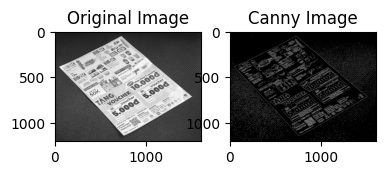

In [3]:
# Reading image
doc_name = 'Image'
img = cv.imread(f'/content/sample_data/{doc_name}.jpg')
assert img is not None, "file could not be read, check with os.path.exists()"

# Define HEIGHT and WIDTH of scanning document
doc_height, doc_width = img.shape[:2]
height, width = (1600, 1200) if doc_height > doc_width else (1200, 1600)

resized = cv.resize(img, (width, height))

img_gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
plt.subplot(131),plt.imshow(img_gray, cmap="gray", vmin=0, vmax=255)
plt.title('Original Image')

edges = cv.Canny(img_gray, 250, 255, apertureSize=3)
plt.subplot(132),plt.imshow(edges, cmap="gray", vmin=0, vmax=255)
plt.title('Canny Image')

plt.ioff()

In [4]:
# Using Hough Transform to detect lines
# Filtering lines appearing more than [(width + height) / 14] times
lines = [np.array(line[0]) for line in cv.HoughLines(edges, 1, np.pi/180, int((width + height) / 12), 0, 0)]

# Classifying lines into likely-verticals and likely-horizontals
verticals = []
horizontals = []
for line in lines:
    if  5 * np.pi / 8 >= line[1] >=  3 * np.pi / 18 :
        horizontals.append(line)
    else:
        verticals.append(line)

# def getDistance(arr: list, isCos: bool):
#     return np.abs(arr[0] * (np.cos if isCos else np.sin)(arr[1]))

# Selected nearest and farthest vertical and horizontal lines as Border edges
#    ____ 1 ____
#   |           |
#   |           |
#   3           4
#   |           |
#   |____ 2 ____|

selected_lines = []
selected_lines.append(min(horizontals, key=lambda line: line[0]))
selected_lines.append(max(horizontals, key=lambda line: line[0]))
selected_lines.append(max(verticals, key=lambda line: line[0]))
selected_lines.append(min(verticals, key=lambda line: line[0]))

<ipython-input-5-f0e47b37ecbd>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x0, y0 = int(np.round(x0)), int(np.round(y0))


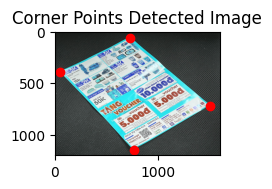

In [5]:
# From 4 border edges, detect 4 corner points as their intersections
# A line (l) is denoted by a perpendicular vector (v) from point O to its projection
#   with rho and theta:
#       + theta: angle between vector and Ox
#       + rho: length of vector
#       + NOTE: Oy is reversed in image procesing
#
# Linear equations of (l) perpendicular to (v) at (rho * cos(theta), rho * sin(theta)):
#       cos(theta) * x + sin(theta) * y = rho
#          ___________________________
# Solving | cos(theta1) | sin(theta1) |  X  |x|  = |rho1|  to get intersection (x, y)
#         | cos(theta2) | sin(theta2) |     |y|    |rho2|
#          ---------------------------

def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

#   p1_________p2
#   |           |
#   |           |
#   |           |
#   |           |
#   p3_________p4
#

corner_points = []
corner_points.append(intersection(selected_lines[0], selected_lines[2]))
corner_points.append(intersection(selected_lines[0], selected_lines[3]))
corner_points.append(intersection(selected_lines[1], selected_lines[2]))
corner_points.append(intersection(selected_lines[1], selected_lines[3]))


plt.subplot(133),plt.imshow(resized, cmap="gray", vmin=0, vmax=255)
plt.title('Corner Points Detected Image')

for point in corner_points:
    plt.plot([point[0]], [point[1]], 'ro') # Draw circles

plt.subplots_adjust(right=1)
plt.show()

In [6]:
# Initialize array (height, width, 3) as last document
documents = np.zeros((height, width, 3), dtype=np.uint8)

# Define converting from (x,y) from last document to corresponding (x', y') in source
#   denoted by a function depending on x, y, and xy
# For example: x' = a * xy + b * x + c * y + d
#          ___________________
# Solving |   0   | 0 | 0 | 1 |  X  |a|  = |p1_x|  to get intersection (a,b,c,d)
#         |   0   | w | 0 | 1 |     |b|    |p2_x|
#         |   0   | 0 | h | 1 |     |c|    |p3_x|
#         | w x h | w | h | 1 |     |d|    |p4_x|
#          -------------------
# Do the same thing for y

# 4x4 Matrix
doc_corner_point_matrix = np.array([
        [0,             0,      0,      1],
        [0,             width,  0,      1],
        [0,             0,      height, 1],
        [height*width,  width,  height, 1]
    ])

# 4x1 Array
x_source_matrix = np.array([[[point[0]] for point in corner_points]])
y_source_matrix = np.array([[[point[1]] for point in corner_points]])


x_param_matrix = np.linalg.solve(doc_corner_point_matrix, x_source_matrix)
y_param_matrix = np.linalg.solve(doc_corner_point_matrix, y_source_matrix)

for y in range(height):
    for x in range(width):
        base_pos = [[y * x, x, y, 1]]
        x_scale = int(np.floor(np.dot(base_pos, x_param_matrix)[0][0]))
        y_scale = int(np.floor(np.dot(base_pos, y_param_matrix)[0][0]))
        documents[y][x] = resized[y_scale][x_scale]

<ipython-input-6-5a3e01c9d6bd>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_scale = int(np.floor(np.dot(base_pos, x_param_matrix)[0][0]))
<ipython-input-6-5a3e01c9d6bd>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_scale = int(np.floor(np.dot(base_pos, y_param_matrix)[0][0]))


In [7]:
cv.imwrite(f'/content/sample_data/scanning_{doc_name}.jpg', documents)

True